<a href="https://colab.research.google.com/github/Rahul9361369275/vehicle/blob/main/yolov5_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#clone git yolov5  
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15002, done.
remote: Total 15002 (delta 0), reused 0 (delta 0), pack-reused 15002
Receiving objects: 100% (15002/15002), 14.08 MiB | 21.39 MiB/s, done.
Resolving deltas: 100% (10285/10285), done.


In [ ]:
#requirements for the yolov5
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00


In [ ]:
#import the dependencies
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#load the data set
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd drive/MyDrive/Vehicle_Rahul/

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:

print(extract_info_from_xml('drive/MyDrive/Vehicle_Rahul/annotated/6010.xml'))

FileNotFoundError: ignored

In [ ]:
class_name_to_id_mapping = {"Two wheeler": 0,
                           "Four wheeler": 1,
                           "motorized three wheeler": 2,
                           "LCV": 3,
                           "HCV":4,
                           "Pedestrian":5 ,
                            "BUS":6}

In [ ]:


# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("drive/MyDrive/Vehicle_Rahul/annotated", info_dict["filename"].replace("png", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join('drive/MyDrive/Vehicle_Rahul/annotated', x) for x in os.listdir('drive/MyDrive/Vehicle_Rahul/annotated') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('drive/MyDrive/Vehicle_Rahul/annotated', x) for x in os.listdir('drive/MyDrive/Vehicle_Rahul/annotated') if x[-3:] == "txt"]

100%|██████████| 991/991 [00:07<00:00, 125.46it/s]


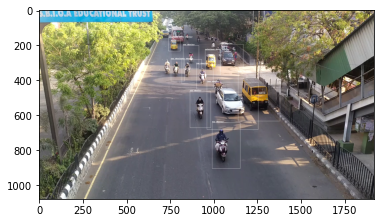

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("drive/MyDrive/Vehicle_Rahul/annotated", "drive/MyDrive/Vehicle_Rahul/images").replace("txt", "png")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join("drive/MyDrive/Vehicle_Rahul/images", x) for x in os.listdir("drive/MyDrive/Vehicle_Rahul/images")]
annotations = [os.path.join("drive/MyDrive/Vehicle_Rahul/annotated", x) for x in os.listdir("drive/MyDrive/Vehicle_Rahul/annotated") if x[-3:] == "txt"]

images.sort()
annotations.sort()
#print(images)
#print(annotations)

# Split the dataset into train-valid-test splits 
#train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
#val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
!mkdir drive/MyDrive/Vehicle_Rahul/images/train drive/MyDrive/Vehicle_Rahul/images/val drive/MyDrive/Vehicle_Rahul/images/test drive/MyDrive/Vehicle_Rahul/annotated/train drive/MyDrive/Vehicle_Rahul/annotated/val drive/MyDrive/Vehicle_Rahul/annotated/test

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'drive/MyDrive/Vehicle_Rahul/images/train')
move_files_to_folder(val_images, 'drive/MyDrive/Vehicle_Rahul/images/val/')
move_files_to_folder(test_images, 'drive/MyDrive/Vehicle_Rahul/images/test/')
move_files_to_folder(train_annotations, 'drive/MyDrive/Vehicle_Rahul/annotated/train/')
move_files_to_folder(val_annotations, 'drive/MyDrive/Vehicle_Rahul/annotated/val/')
move_files_to_folder(test_annotations, 'drive/MyDrive/Vehicle_Rahul/annotated/test/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.7/462.7 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 508.4/508.4 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3

In [ ]:
!python yolov5/train.py --img 576 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 10 --data vehicle.yaml --weights yolov5s.pt --workers 24 --name yolo_vehicle

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=vehicle.yaml, hyp=hyp.scratch-low.yaml, epochs=10, batch_size=32, imgsz=576, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolo_vehicle, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degre

In [ ]:
 !python yolov5/detect.py --source drive/MyDrive/Vehicle_Rahul/images/test/ --weights yolov5/runs/train/yolo_vehicle10/weights/best.pt --conf 0.25 --name yolo_vehicle_v8

detect: weights=['yolov5/runs/train/yolo_vehicle10/weights/best.pt'], source=drive/MyDrive/Vehicle_Rahul/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_vehicle_v8, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.8.10 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
image 1/100 /content/drive/MyDrive/Vehicle_Rahul/images/test/10020.png: 384x640 3 Two wheelers, 6 Four wheelers, 1 motorized three wheeler, 264.6ms
image 2/100 /content/drive/MyDrive/Vehicle_Rahul/images/test/10030.png: 384x640 3 Two wheelers, 7 Four wheelers, 1 motorized three wheeler, 230.1ms
image 3/